Consider the following system:
$$
reaction 1: A + B \longrightarrow C \\
reaction 2: C + B \longrightarrow D \\
reaction 3: A + D \longrightarrow 2C \\
$$
with the following preexponential constant and activation temperature (ignore temperature exponenet):
$$
A_{f1} = 1, T_{a1} = 1000 \\
A_{f2} = 10, T_{a2} = 500 \\
A_{f3} = 1, T_{a3} = 1000 \\
$$

Then the progress rate of the 3 reactions can be expressed as:
$$
Q_1 = K_{f1} \cdot [X_A][X_B] \\
Q_2 = K_{f2} \cdot [X_B][X_C] \\
Q_3 = K_{f3} \cdot [X_A][X_D] \\
$$
where $[X_A],[X_B],[X_C],[X_D]$ are molar concentration of $A, B, C, D$， and the reaction rates are
$$
K_{f1} = 1 \cdot \exp(-\frac{1000}{T}) \\
K_{f2} = 10 \cdot \exp(-\frac{500}{T}) \\
K_{f3} = 1 \cdot \exp(-\frac{1000}{T}) 
$$.

This gives us the following ODE system:
$$
\frac{d[X_A]}{dt} = -Q_1 -Q_3 \\
\frac{d[X_B]}{dt} = -Q_1 -Q_2 \\
\frac{d[X_C]}{dt} = Q_1 -Q_2 +2Q_3 \\
\frac{d[X_D]}{dt} = Q_2 -Q_3
$$


In [3]:
import numpy as np
from neurodiffeq import diff      
from neurodiffeq.ode import solve_system, IVP, Monitor
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


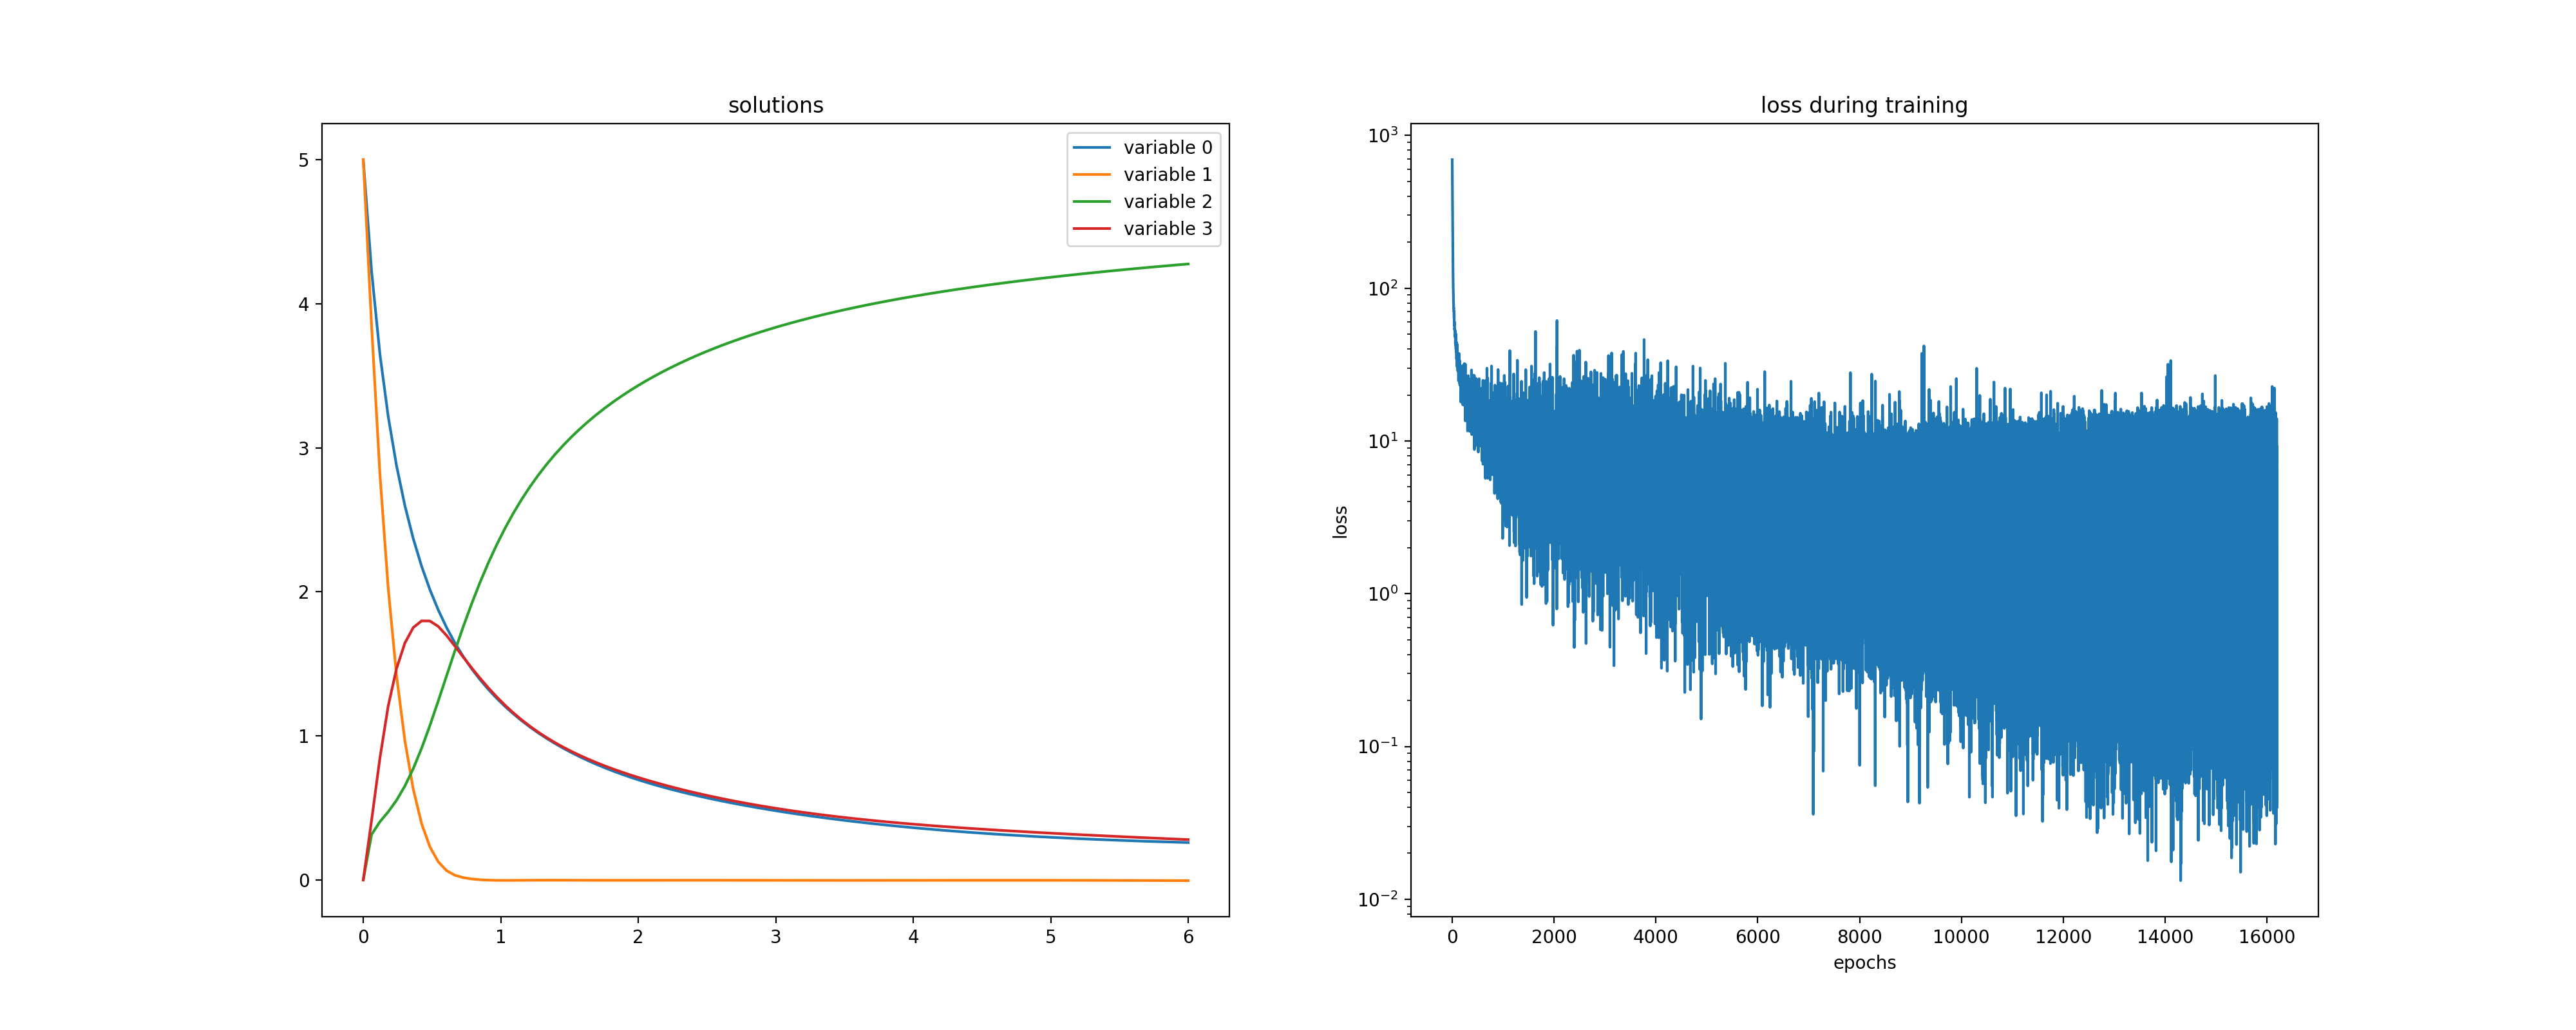

In [4]:
# specify the ODE system
# A + B -> C, K1
# C + B -> D, K2
# A + D -> 2C, K3
T = 2000
K1 = 1 * np.exp(-1000/T)
K2 = 10 * np.exp(-500/T)
K3 = 1 * np.exp(-1000/T)
Q1 = lambda a, b: K1*a*b
Q2 = lambda b, c: K2*b*c
Q3 = lambda a, d: K3*a*d
reaction = lambda a, b, c, d, t : [
    diff(a, t) - (-Q1(a, b) -Q3(a, d)), 
    diff(b, t) - (-Q1(a, b) -Q2(b, c)),
    diff(c, t) - (Q1(a, b) -Q2(b, c) +2*Q3(a, d)),
    diff(d, t) - (Q2(b, c) -Q3(a, d))
]

# specify the initial conditions
init_vals_reaction = [
    IVP(t_0=0.0, x_0=5.0),
    IVP(t_0=0.0, x_0=5.0),
    IVP(t_0=0.0, x_0=0.0),
    IVP(t_0=0.0, x_0=0.0)
]

# solve the ODE system
solution_reaction, _ = solve_system(
    ode_system=reaction, 
    conditions=init_vals_reaction, 
    t_min=0.0, t_max=5.0,
    monitor=Monitor(t_min=0.0, t_max=6.0, check_every=100),
    tol=1e-2
                                   )

<IPython.core.display.Javascript object>


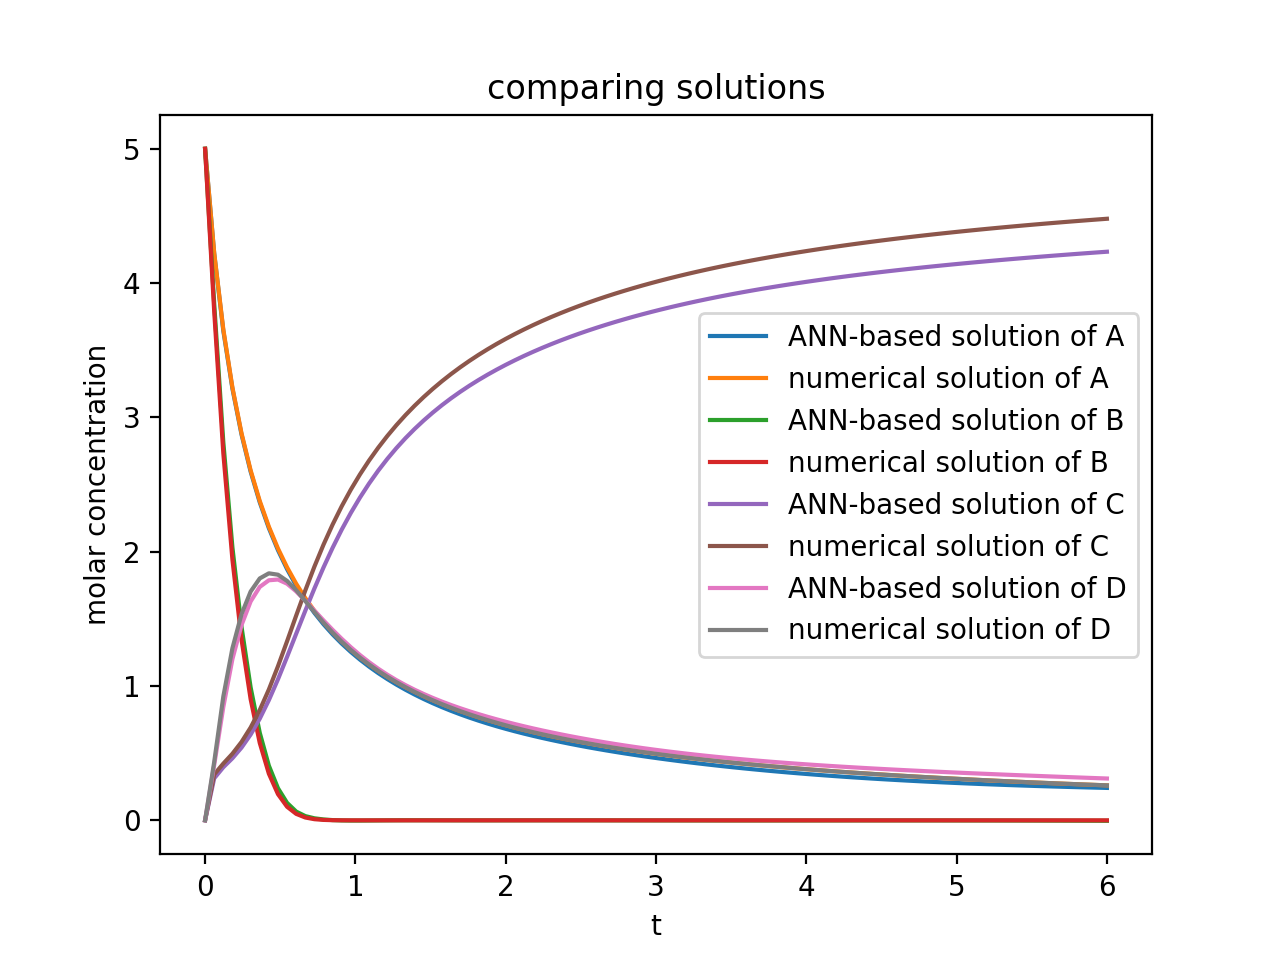

In [5]:
ts = np.linspace(0, 6, 100)

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    a, b, c, d = P
    return [
        -Q1(a, b) -Q3(a, d), 
        -Q1(a, b) -Q2(b, c),
        Q1(a, b) -Q2(b, c) +2*Q3(a, d),
        Q2(b, c) -Q3(a, d)
    ]
#     return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [5.0, 5.0, 0.0, 0.0]
Ps = odeint(dPdt, P0, ts)
A_num = Ps[:,0]
B_num = Ps[:,1]
C_num = Ps[:,2]
D_num = Ps[:,3]
A_net, B_net, C_net, D_net = solution_reaction(ts)

plt.figure()
plt.plot(ts, A_net, label='ANN-based solution of A')
plt.plot(ts, A_num, label='numerical solution of A')
plt.plot(ts, B_net, label='ANN-based solution of B')
plt.plot(ts, B_num, label='numerical solution of B')
plt.plot(ts, C_net, label='ANN-based solution of C')
plt.plot(ts, C_num, label='numerical solution of C')
plt.plot(ts, D_net, label='ANN-based solution of D')
plt.plot(ts, D_num, label='numerical solution of D')
plt.ylabel('molar concentration')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()